In [1]:
import tensorflow as tf
from models import fcn16_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
import os
from utils import load_and_preprocess_image, load_and_preprocess_label, augment 

2023-08-25 13:59:09.735090: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-25 13:59:09.879337: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
train_img_path =  '/home/cityscapes-segmentation/dataset/rgb/train'
train_mask_path = '/home/cityscapes-segmentation/dataset/mask/train'
test_img_path = '/home/cityscapes-segmentation/dataset/rgb/test'
test_mask_path = '/home/cityscapes-segmentation/dataset/mask/test'

In [3]:
train_img = [os.path.join(train_img_path, imgname) for imgname in os.listdir(train_img_path) if imgname != '.DS_Store']
train_mask = [os.path.join(train_mask_path, imgname) for imgname in os.listdir(train_mask_path) if imgname != '.DS_Store']
test_img = [os.path.join(test_img_path, imgname) for imgname in os.listdir(test_img_path) if imgname != '.DS_Store']
test_mask = [os.path.join(test_mask_path, imgname) for imgname in os.listdir(test_mask_path) if imgname != '.DS_Store']

In [4]:
# Membuat dataset
train_img_dataset = tf.data.Dataset.from_tensor_slices(train_img).map(load_and_preprocess_image)
train_mask_dataset = tf.data.Dataset.from_tensor_slices(train_mask).map(load_and_preprocess_label)
train_dataset = tf.data.Dataset.zip((train_img_dataset, train_mask_dataset)).map(augment)

test_img_dataset = tf.data.Dataset.from_tensor_slices(test_img).map(load_and_preprocess_image)
test_mask_dataset = tf.data.Dataset.from_tensor_slices(test_mask).map(load_and_preprocess_label)
test_dataset = tf.data.Dataset.zip((test_img_dataset, test_mask_dataset))

2023-08-25 13:59:13.655660: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-25 13:59:13.842438: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1637] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22993 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:1e:00.0, compute capability: 7.5


In [5]:
# Optional: Shuffle, batch, and prefetch
batch_size = 4
train_dataset = train_dataset.shuffle(buffer_size=300).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [6]:
model = fcn16_model(input_shape=(192,256,3), filters=64, num_classes=12)
model.summary()

Model: "FCN16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 192, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 192, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [7]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
                   loss="sparse_categorical_crossentropy",
                   metrics=["accuracy", tf.keras.metrics.MeanIoU(12, sparse_y_pred=False)])

In [8]:
# ReduceLROnPlateau and ModelCheckpoint callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8,
                              patience=5, min_lr=1e-5)
model_checkpoint = ModelCheckpoint(filepath='checkpoint/fcn16_300epoch',
                                            save_weights_only=True,
                                            save_best_only=True,
                                            monitor='val_loss',
                                            verbose=1)
early_stop = tf.keras.callbacks.EarlyStopping(patience=50)
tensorboard = TensorBoard(log_dir='fcn16logs', write_graph=True, update_freq='batch')

In [9]:
model_history = model.fit(train_dataset,
                               epochs=300,
                               validation_data=test_dataset, callbacks=[reduce_lr,model_checkpoint,early_stop, tensorboard])

Epoch 1/300


2023-08-25 13:59:18.492582: I tensorflow/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8700


92/92 [==============================] - ETA: 0s - loss: 2.0169 - accuracy: 0.3817 - mean_io_u: 0.0731
Epoch 1: val_loss improved from inf to 1.84145, saving model to checkpoint/fcn16_300epoch
92/92 [==============================] - 7s 46ms/step - loss: 2.0169 - accuracy: 0.3817 - mean_io_u: 0.0731 - val_loss: 1.8415 - val_accuracy: 0.4811 - val_mean_io_u: 0.1055 - lr: 0.0010
Epoch 2/300
92/92 [==============================] - ETA: 0s - loss: 1.4905 - accuracy: 0.5188 - mean_io_u: 0.1144
Epoch 2: val_loss improved from 1.84145 to 1.60745, saving model to checkpoint/fcn16_300epoch
92/92 [==============================] - 4s 38ms/step - loss: 1.4905 - accuracy: 0.5188 - mean_io_u: 0.1144 - val_loss: 1.6074 - val_accuracy: 0.4863 - val_mean_io_u: 0.1060 - lr: 0.0010
Epoch 3/300
92/92 [==============================] - ETA: 0s - loss: 1.3334 - accuracy: 0.5483 - mean_io_u: 0.1218
Epoch 3: val_loss improved from 1.60745 to 1.40711, saving model to checkpoint/fcn16_300epoch
92/92 [========

In [10]:
pred = model.predict(test_dataset)

26/26 [==============================] - 1s 9ms/step


In [11]:
def show_pred(predictions, index=0):
    img = plt.imread(test_img[index])
    mask = plt.imread(test_mask[index]) * 255
    pred_img = np.argmax(predictions[index], axis=-1)
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(img)
    axes[0].set_title('Image')
    axes[1].imshow(mask)
    axes[1].set_title('True Mask')
    axes[2].imshow(pred_img)
    axes[2].set_title('Predicted FCN16')

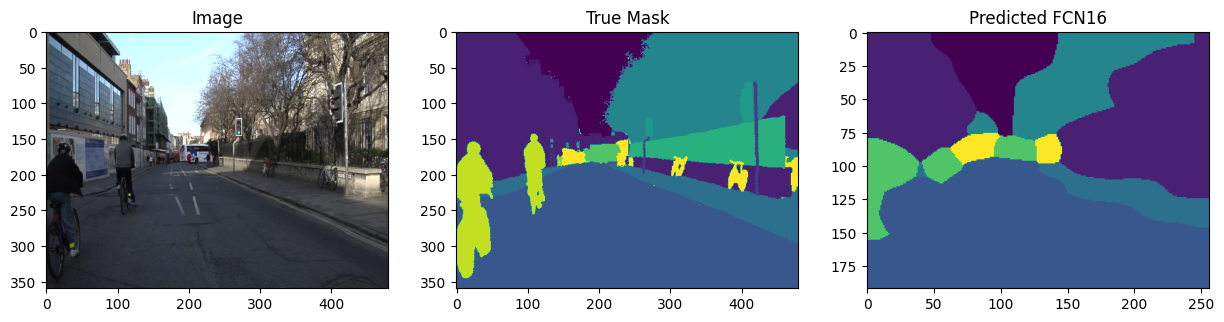

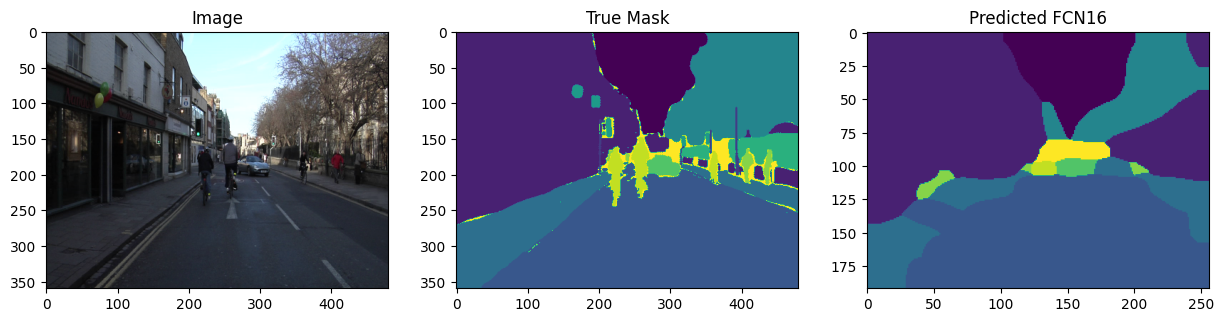

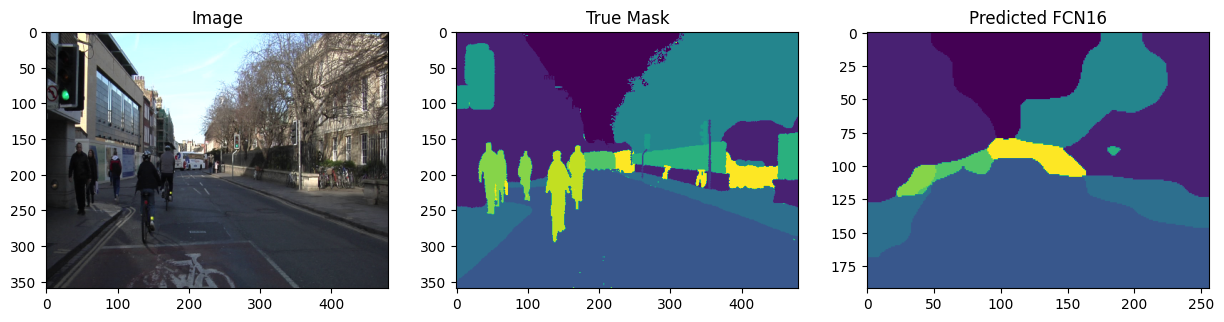

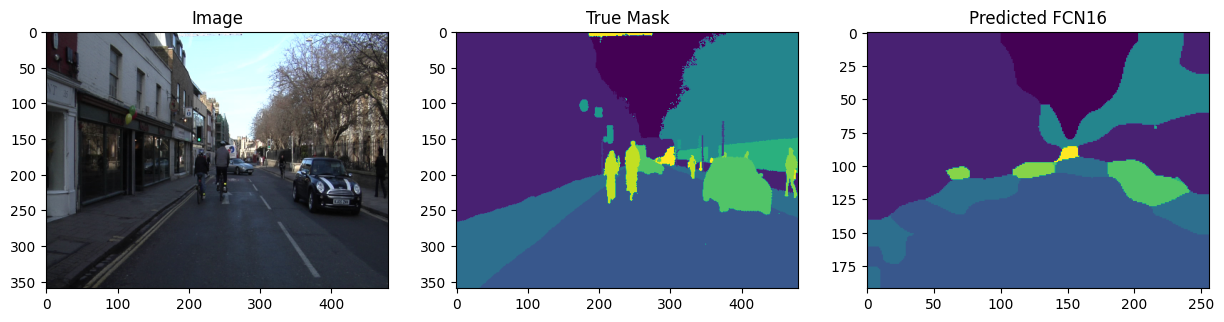

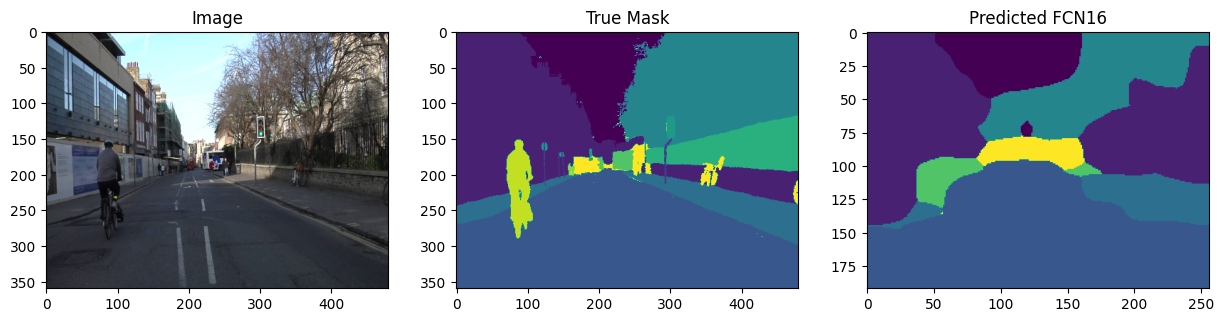

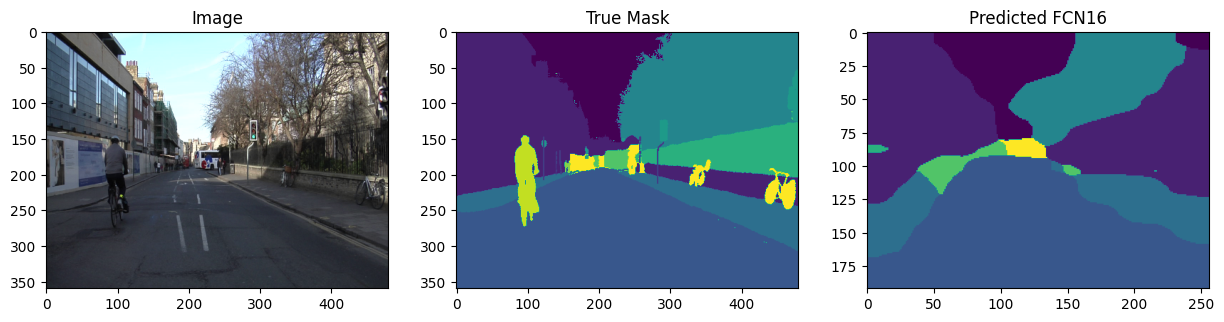

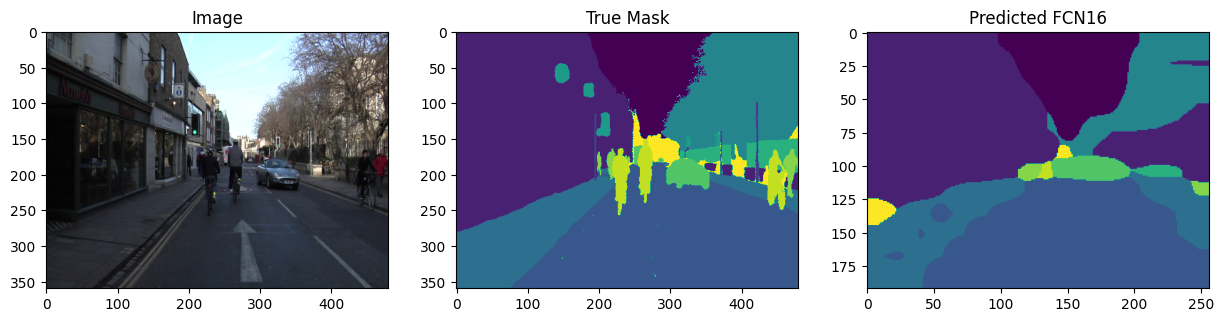

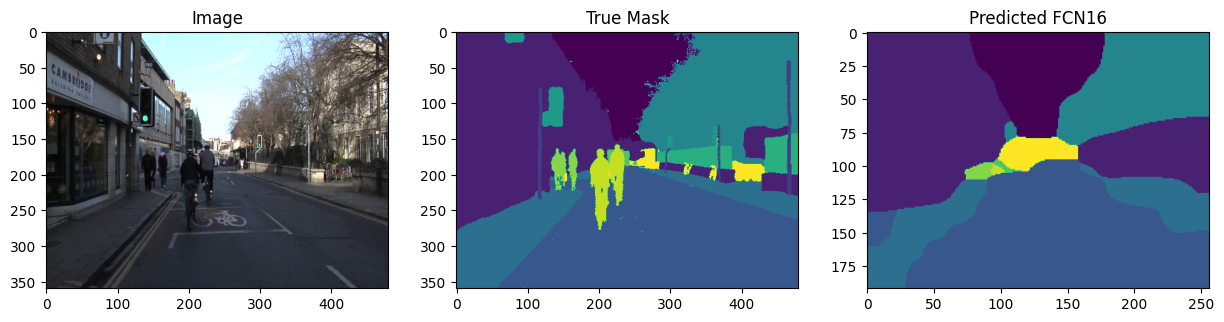

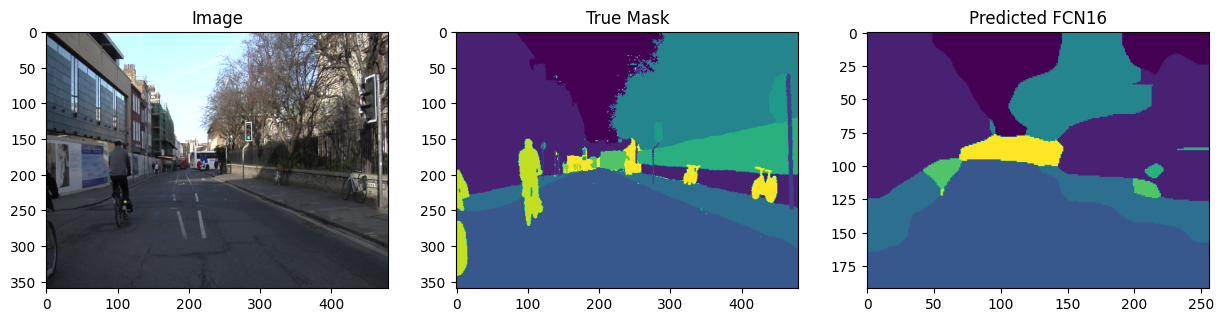

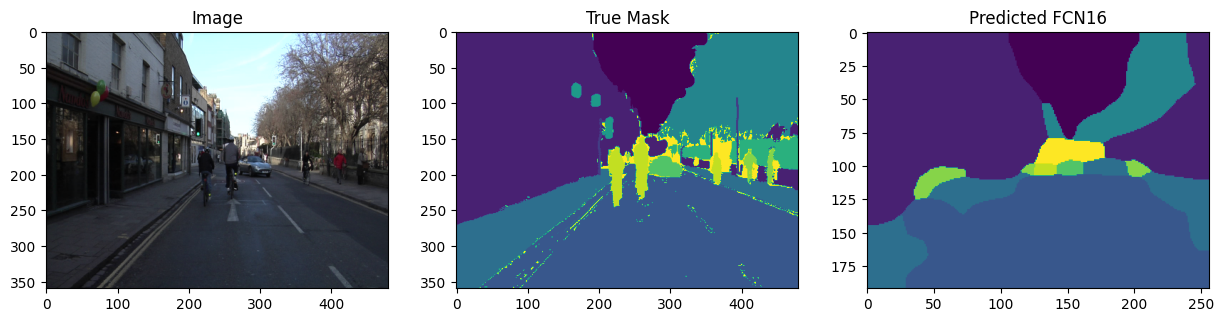

In [12]:
for i in range(1,100,10):
    show_pred(pred, i)